# The Key To Toronto Realestate Pricing (Maybe)

#### Capstone Notebook 2/2
---

# Table of Contents
- [Introduction](#Introduction)
- [Data_Dictionary](#Data_Dictionary)
- [Data Transformation](#Transforming)
- [Model_Selection](#Model_Selection)
- [Parameter_Optimization](#Parameter_Optimization)
 - [XGBoost](#XGBoost)
 - [RandomForest](#RandomForest)
- [Conclusions](#Conclusions)
---

## Introduction
In the previous notebook, optimization was not possible for a basic linear regression as there were difficulties interpreting the results. This notebook will attempt to dive into more advanced machine learning models and optimization techniques to be implemented to improve on the model's performance. The data is taken from the processed results of the last notebook. Data was cleaned (removal of null/duplicates/etc) and processed (conversion of categorical columns to numeric) in creating dataset that can be properly assessed and worked on.


## Data_Dictionary

To help us with our analysis, please refer to the data dictionary below. 
**Note: All data is numeric.**

Data about location:

- dist_ : these are the dummy variables of each district (total 140) in the GTA 
    - [Toronto Disctrict Dataset](https://open.toronto.ca/dataset/neighbourhood-profiles/)

Data about the home listed:

- total_bedrooms: total number of bedrooms
- bathrooms: number of bathrooms in the home
- sqft: total surface area of the home represented by square footage
- parking: number of parking spaces mostly based on number of cars that can fit in the lot
- bedrooms_ag: number of bedrooms above ground (numeric)
- is_house: a boolean value of wether or not the home is a house

Data about the listing: 

- final_price: price to which the home was sold (numeric)
- list_price: price to which the home was listed (numeric)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import urllib.request
import seaborn as sns
import time
import bs4 as bs
from scipy import stats
import plotly.express as px
# from bokeh.plotting import figure, show
%matplotlib inline

sns.set_theme() # set chart visualization 
sns.set_palette('winter') # winter aesthetic

# remove scientific notation from grouping display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
houses = pd.read_csv('Data/houses_edited.csv', index_col='index')
houses.head(1)

,title,final_price,list_price,bedrooms,bathrooms,sqft,parking,description,mls,type,...,full_address,lat,long,city_district,mean_district_income,district_code,final_price_transformed,final_price_log,bedrooms_ag,bedrooms_bg
index,,,,,,,,,,,,,,,,,,,,,
0,"1303 - 38 Grenville St, Toronto (C4461599) | Z...",855000,870000,2 + 1 beds,2,850.000,1,"Luxurious And Spacious Murano Tower. 2+1, 2 Ba...",C4461599,Condo Apt,...,"38 Grenville St, Toronto , Ontario, Canada",43.662,-79.386,Bay Street Corridor,56526,76,2.392,13.659,2,1


In [3]:
processed_houses = pd.read_csv('Data/processed_houses.csv')
processed_houses_w_dummies = pd.read_csv('Data/processed_houses_w_dummies.csv')

Sanity check for DataFrames

In [4]:
processed_houses.sample(1)

,df_index,final_price,list_price,bathrooms,parking,lat,long,mean_district_income,sqft,bedrooms_ag,total_bedrooms,is_house
8721,10931,2850000,2899999,7,6,43.711,-79.440,48134,2310.148,4,6,1


In [5]:
processed_houses_w_dummies.sample(1)

,df_index,final_price,list_price,bathrooms,parking,lat,long,mean_district_income,sqft,bedrooms_ag,...,dist_Willowdale West,dist_Willowridge-Martingrove-Richview,dist_Woburn,dist_Woodbine Corridor,dist_Woodbine-Lumsden,dist_Wychwood,dist_Yonge-Eglinton,dist_Yonge-St.Clair,dist_York University Heights,dist_Yorkdale-Glen Park
4144,6143,630000,645000,1,1,43.704,-79.400,89330,650.000,1,...,0,0,0,0,0,0,1,0,0,0


## Transforming
### Transforming the Data for Modelling

Previously we already transformed data through Boxcox, so this upcoming step is not necessary. One problem with Boxcox

An unexpected issue with Boxcox was conveniently reverting transformed values. It cannot convert negative values, which conflicts when attempting to process a wide variety of models that produce positive as well as negative predictions. For this reason, the Yeo-Johnson transformation was considered instead.
> The Yeo-Johnson transformation can be thought of as an extension of the Box-Cox transformation. It handles both positive and negative values, whereas the Box-Cox transformation only handles positive values. Both can be used to transform the data so as to improve normality.
>
> [Yeo-Johnson and Boxcox in Jupyter Notebooks](https://www.youtube.com/watch?v=ev7wkRL8OUk&ab_channel=RachitToshniwal)

#### Transform data using Yeo-Johnson power transformer

In [6]:
from sklearn.preprocessing import PowerTransformer

In [7]:
processed_houses_w_dummies_yeo = processed_houses_w_dummies.copy()
# adjust values for the transformation=
processed_houses_w_dummies_yeo['mean_district_income'] = processed_houses.mean_district_income/100
processed_houses_w_dummies_yeo['final_price'] = processed_houses.final_price/100
processed_houses_w_dummies_yeo['list_price'] = processed_houses.list_price/100


yeo_johnson_lambdas = [] 

numeric_feats = ['sqft', 'mean_district_income', 'final_price', 'list_price']

pt = PowerTransformer(method='yeo-johnson')
for numeric_feat in numeric_feats:
    processed_houses_w_dummies_yeo[numeric_feat] = pt.fit_transform(processed_houses_w_dummies_yeo[[numeric_feat]])
    yeo_johnson_lambdas.append(pt.lambdas_[0])


In [8]:
processed_houses_w_dummies_yeo.head()

,df_index,final_price,list_price,bathrooms,parking,lat,long,mean_district_income,sqft,bedrooms_ag,...,dist_Willowdale West,dist_Willowridge-Martingrove-Richview,dist_Woburn,dist_Woodbine Corridor,dist_Woodbine-Lumsden,dist_Wychwood,dist_Yonge-Eglinton,dist_Yonge-St.Clair,dist_York University Heights,dist_Yorkdale-Glen Park
0,0,0.339,0.406,2,1,43.662,-79.386,0.456,-0.681,2,...,0,0,0,0,0,0,0,0,0,0
1,1,0.406,0.467,2,6,43.647,-79.530,0.291,0.592,3,...,0,0,0,0,0,0,0,0,0,0
2,2,-0.606,-0.579,1,0,43.708,-79.397,0.477,-1.323,1,...,0,0,0,0,0,0,0,0,0,0
3,3,-0.178,-0.376,1,1,43.638,-79.414,0.929,-1.086,1,...,0,0,0,0,0,0,0,0,0,0
4,4,0.270,0.336,2,1,43.597,-79.510,-0.187,1.139,2,...,0,0,0,0,0,0,0,0,0,0


Import PowerTransformer, MAE / RMSE

Plot new distribution of transformed data

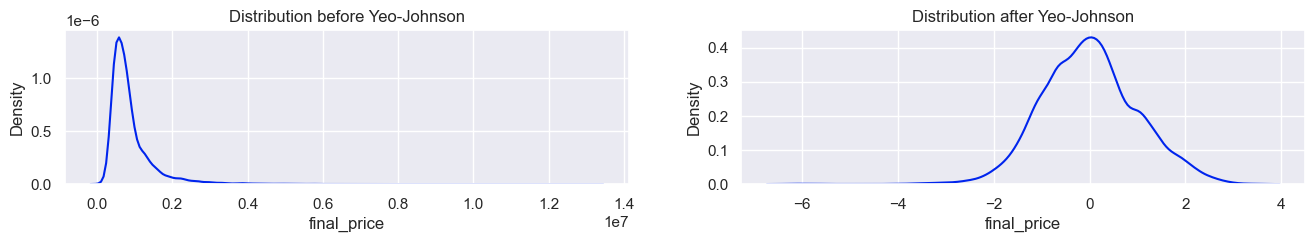

Text(0.5, 1.0, 'Distribution after Yeo-Johnson')

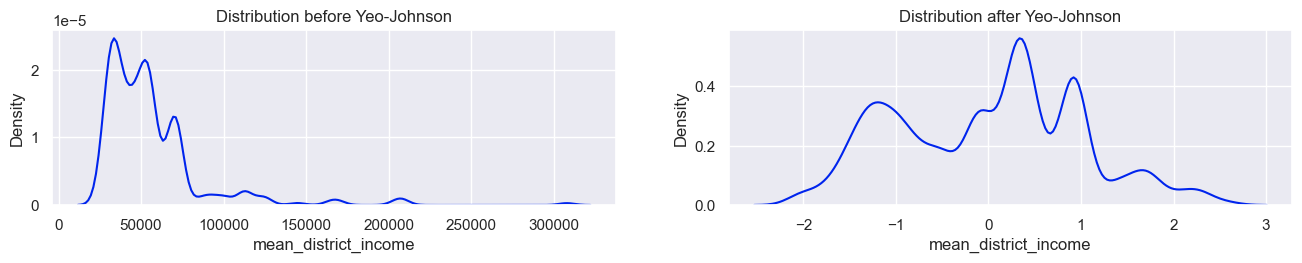

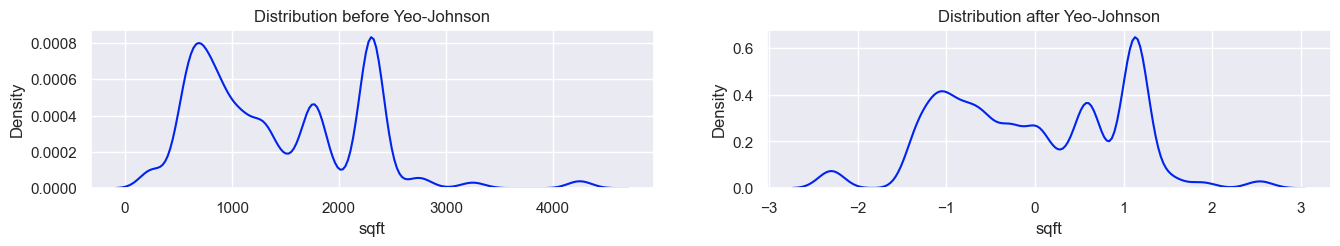

In [9]:
# Effect of yeo on final_price
plt.figure(1, figsize=[16,2])
ax1=plt.subplot(1,2,1)
sns.kdeplot(processed_houses['final_price'])
ax1.set_title('Distribution before Yeo-Johnson')

ax2=plt.subplot(1,2,2)
sns.kdeplot(processed_houses_w_dummies_yeo['final_price'])
ax2.set_title('Distribution after Yeo-Johnson')
plt.show()

# Effect of YJ transformation on final_price
plt.figure(2, figsize=[16,5])
ax1=plt.subplot(2,2,1)
sns.kdeplot(processed_houses['mean_district_income'])
ax1.set_title('Distribution before Yeo-Johnson')

ax2=plt.subplot(2,2,2)
sns.kdeplot(processed_houses_w_dummies_yeo['mean_district_income'])
ax2.set_title('Distribution after Yeo-Johnson')

# Effect of YJ transformation on final_price
plt.figure(3, figsize=[16,7])
ax1=plt.subplot(3,2,1)
sns.kdeplot(processed_houses['sqft'])
ax1.set_title('Distribution before Yeo-Johnson')

ax2=plt.subplot(3,2,2)
sns.kdeplot(processed_houses_w_dummies_yeo['sqft'])
ax2.set_title('Distribution after Yeo-Johnson')



> Data has been better normalized after transformations

#### Train/Test Split for transformed values

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(processed_houses_w_dummies_yeo.drop(columns="final_price"), 
                                                    processed_houses_w_dummies_yeo['final_price'], train_size=0.7)

#### Using the MAE and RMSE to evaluate models

Create custom evaluation functions. First, transform both predicted and actual values to dollars and evaluate through one of these four metrics:

$$ \text{Mean squared error (MSE)}  = \frac{1}{n}\sum_{i=1}^{n}(y_i - x_i) ^2 $$

$$ \text{Root mean squared error (RMSE)}  = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - x_i)  ^2} $$

$$ \text{Mean absolute error (MAE)} = \frac{1}{n}\sum_{i=1}^{n}|y_i - x_i  | $$

$$ \text{Mean absolute percentage error (MAPE)} = \frac{100\%}{n}\sum_{i=1}^{n} |\frac{y_i - x_i }{y_i}| $$

In [11]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error
def custom_mae_(y, y_pred, **kwargs):
    # reduce prediction values that are too large
    y_pred[y_pred > 5] = 5
    # revert function back to original values
    y = pt.inverse_transform(pd.DataFrame(y)) * 100
    y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
    return mean_absolute_error(y, y_pred)

custom_mae = make_scorer(custom_mae_, greater_is_better=False)

def custom_mape_(y, y_pred, **kwargs):
    # reduce prediction values that are too large
    y_pred[y_pred > 5] = 5
    # revert function back to original values
    y = pt.inverse_transform(pd.DataFrame(y)) * 100
    y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
    return np.mean(np.abs((y - y_pred) / y)) * 100

custom_mape = make_scorer(custom_mape_, greater_is_better=False)


def custom_rmse_(model, x_test, y, **kwargs):
    # reduce prediction values that are too large
    y_pred = model.predict(x_test)
    y_pred[y_pred > 5] = 5
    # revert function back to original values
    y = pt.inverse_transform(pd.DataFrame(y)) * 100
    y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
    return (mean_squared_error(y, y_pred, squared = False))

custom_rmse = make_scorer(custom_rmse_, greater_is_better=False)

Now we can create estimator space and preselect 20 models that might contribute to our solution. Then we’ll run every algorithm through our train set, cross validate the results and save everything to one dataframe.

## Model_Selection
### Choosing the right models

Try calculating mean absolute and mean squared error with one base regressor then run the same process with a bunch of other models

In [12]:
from sklearn.model_selection import ShuffleSplit, cross_validate, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error

Import bayesian ridge and calculate **RMSE** and **MAE**

In [13]:
from sklearn.linear_model import BayesianRidge

Calculate Bayesian Ridge for MAE

In [14]:
MLA = BayesianRidge()
cv_split = KFold(n_splits=4, shuffle=True, random_state=10)
cv_results = cross_validate(MLA, X_train, y_train, cv  = cv_split, return_train_score=True, scoring=custom_mae)
cv_results

{'fit_time': array([0.10957384, 0.08155417, 0.07501411, 0.081815  ]),
 'score_time': array([0.00469708, 0.00392389, 0.00408983, 0.00344491]),
 'test_score': array([-44373.67216393, -43315.0150696 , -45211.51064077, -45988.75893636]),
 'train_score': array([-44071.48338864, -44148.95480617, -43901.51525123, -43571.85084776])}

Calculate Bayesian Ridge for RMSE

In [15]:
MLA = BayesianRidge()
cv_split = KFold(n_splits=4, shuffle=True, random_state=10)
cv_results = cross_validate(MLA, X_train, y_train, cv  = cv_split, return_train_score=True, scoring=custom_rmse_)
cv_results

{'fit_time': array([0.07737899, 0.08340001, 0.07388496, 0.09888315]),
 'score_time': array([0.00342894, 0.00347686, 0.003335  , 0.00318003]),
 'test_score': array([115873.04045817,  83236.70430298,  97763.4658427 , 118046.73383378]),
 'train_score': array([ 99035.85766638, 106946.16211802, 105924.69288184,  97656.3583262 ])}

Utilize this method and calculate MAE and RMSE for a list of regressors

Import a bunch of regressors to test

In [16]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, ARDRegression, BayesianRidge, HuberRegressor, LarsCV, OrthogonalMatchingPursuitCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.isotonic import  IsotonicRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
# score metrics
from sklearn.metrics import make_scorer
# xgboost is not apart of sklearn library
import xgboost as xgb
import lightgbm as lgb


/Users/arnoldwang/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Run for loop to check each regressor

In [17]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    BaggingRegressor(),
    GradientBoostingRegressor(),

    #Boosting
    xgb.XGBRegressor(objective='reg:squarederror'),
    AdaBoostRegressor(),
    lgb.LGBMRegressor(),

    #KNN
    KNeighborsRegressor(),
    #SVM
    NuSVR(),
    SVR(),
    
    #Tree Models
    DecisionTreeRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),    

    ]


#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = KFold(n_splits=4, shuffle=True, random_state=10) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = []
MLA_algos = pd.DataFrame(columns = MLA_columns)

#index through MLA and save performance to table
row_index = 0
# run for loop to evaluate each model (calculate RMSE and MAE)
for alg in MLA:
    print(f'Starting_{alg}' , end="_")
    #set name and parameters
    MLA_name = alg.__class__.__name__

    MLA_algos.loc[row_index, 'MLA Name'] = MLA_name
    MLA_algos.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
    cv_results_mae = cross_validate(alg, X_train, y_train, cv  = cv_split,
                               return_train_score=True, scoring=custom_mae)

    MLA_algos.loc[row_index, 'Total Time MAE'] = cv_results_mae['fit_time'].sum()
    MLA_algos.loc[row_index, 'MLA Train MAE Mean'] = -cv_results_mae['train_score'].mean()
    MLA_algos.loc[row_index, 'MLA Test MAE Mean'] = -cv_results_mae['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_algos.loc[row_index, 'MLA Test MAE 3*STD'] = cv_results_mae['test_score'].std()*3

    cv_results_rmse = cross_validate(alg, X_train, y_train, cv  = cv_split,
                                    return_train_score=True, scoring=custom_rmse_)
    
    MLA_algos.loc[row_index, 'Total Time RMSE'] = cv_results_rmse['fit_time'].sum()
    MLA_algos.loc[row_index, 'MLA Train RMSE Mean'] = cv_results_rmse['train_score'].mean()
    MLA_algos.loc[row_index, 'MLA Test RMSE Mean'] = cv_results_rmse['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_algos.loc[row_index, 'MLA Test RMSE 3*STD'] = cv_results_rmse['test_score'].std()*3
    
    
    MLA_algos.loc[row_index, 'Total_Time'] = (cv_results_rmse['fit_time'].sum()+cv_results_mae['fit_time'].sum())
    
    print(f'Done_{MLA_name}' , end="_")
    row_index+=1
    
MLA_algos

Starting_BaggingRegressor()_Done_BaggingRegressor_Starting_GradientBoostingRegressor()_Done_GradientBoostingRegressor_Starting_XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)_Done_XGBRegressor_Starting_AdaBoostRegressor()_Done_AdaBoostRegressor_Starting_LGBMRegressor()_Done_LGBMRegressor_Starting_KNeighborsRegressor()_Done_KNeighborsRegressor_Starting_NuSVR()_Done_NuSVR_Starting_SVR()_Done_SVR_Starting_DecisionTreeRegress

,MLA Name,MLA Parameters,Total Time MAE,MLA Train MAE Mean,MLA Test MAE Mean,MLA Test MAE 3*STD,Total Time RMSE,MLA Train RMSE Mean,MLA Test RMSE Mean,MLA Test RMSE 3*STD,Total_Time
0,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",2.115,17324.773,43814.751,3376.577,2.072,49995.760,99036.134,65638.558,4.187
1,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",6.278,39850.106,42706.553,3717.907,6.198,89085.565,103978.942,92646.891,12.476
2,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",4.893,25250.840,42057.426,3888.702,4.897,48462.762,89256.025,53257.350,9.790
3,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",3.170,79750.062,80284.305,22993.465,3.133,198392.861,186083.062,91197.290,6.303
4,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",0.578,37777.058,44844.087,5802.626,0.550,147683.613,163379.788,137199.092,1.129
5,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.021,285169.059,345755.490,18273.340,0.017,572945.855,640512.486,68849.321,0.038
6,NuSVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",16.868,351279.985,351439.085,14339.973,16.885,664428.547,664188.925,64523.212,33.753
7,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",21.727,351211.196,351390.976,14301.896,21.704,664727.977,664484.877,64935.855,43.432
8,DecisionTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_de...",0.349,-0.000,55814.274,7165.829,0.349,0.000,148858.275,172807.865,0.698
9,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",16.324,0.000,42634.162,4010.399,16.374,0.000,99176.236,62170.743,32.699


> Removed the following models as they had a MAE or RMSE too high relative to the others
>
>     PLSRegression()
>     RidgeCV()
>     KernelRidge()
>     HuberRegressor()
>     LinearRegression()
>     LarsCV()
>     BayesianRidge()
>     make_pipeline(RobustScaler(), LassoCV())
>     make_pipeline(RobustScaler(), ElasticNetCV())
>     OrthogonalMatchingPursuitCV()

Plot results of MAE, RMSE and Time

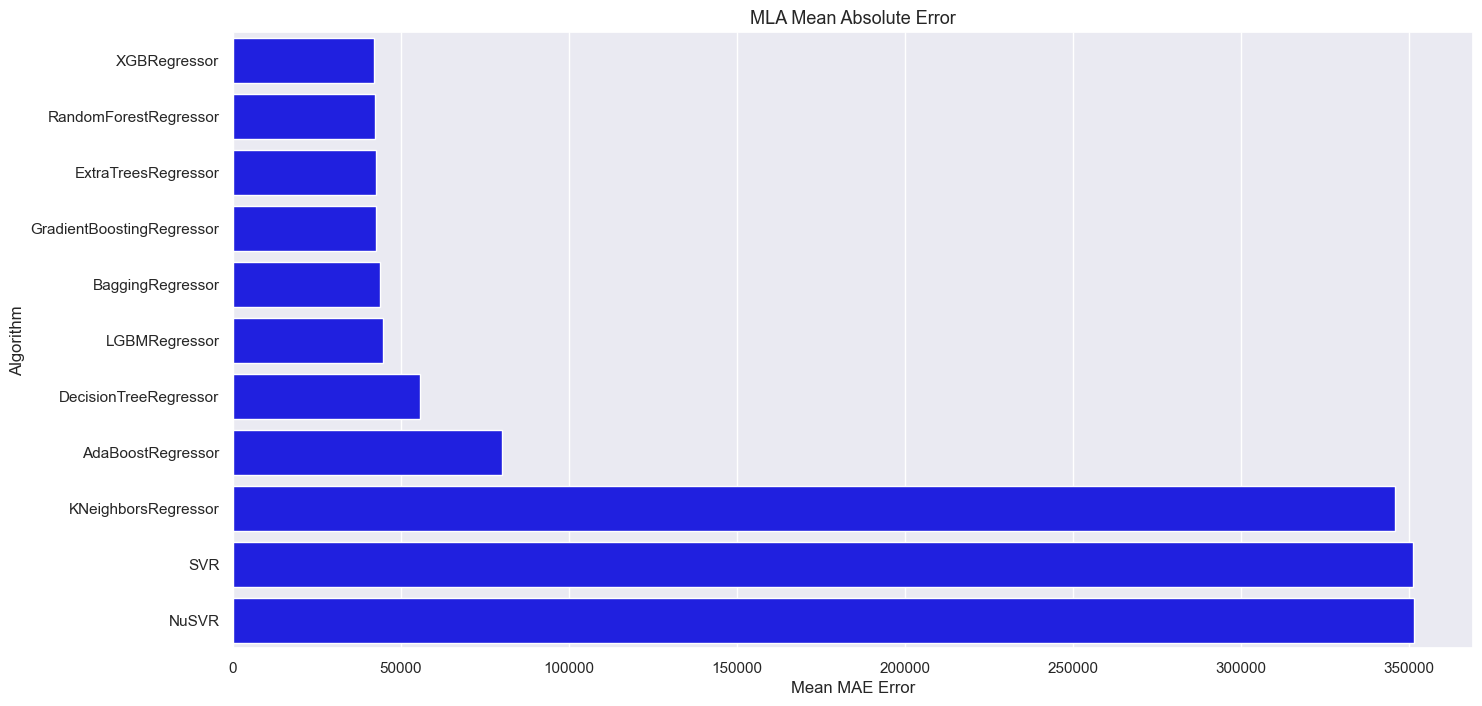

In [18]:
MLA_algos.sort_values('MLA Test MAE Mean', inplace = True, ascending = True)

fig, ax = plt.subplots(figsize = [16,8])

sns.barplot(x = 'MLA Test MAE Mean', y = 'MLA Name', data = MLA_algos, color = 'blue')
plt.title('MLA Mean Absolute Error', fontsize=13)
plt.xlabel('Mean MAE Error')
plt.ylabel('Algorithm')
plt.show()

> Top 6 appear to be roughly the same

> Notice a considerable drop off between AdaBoost and KNN

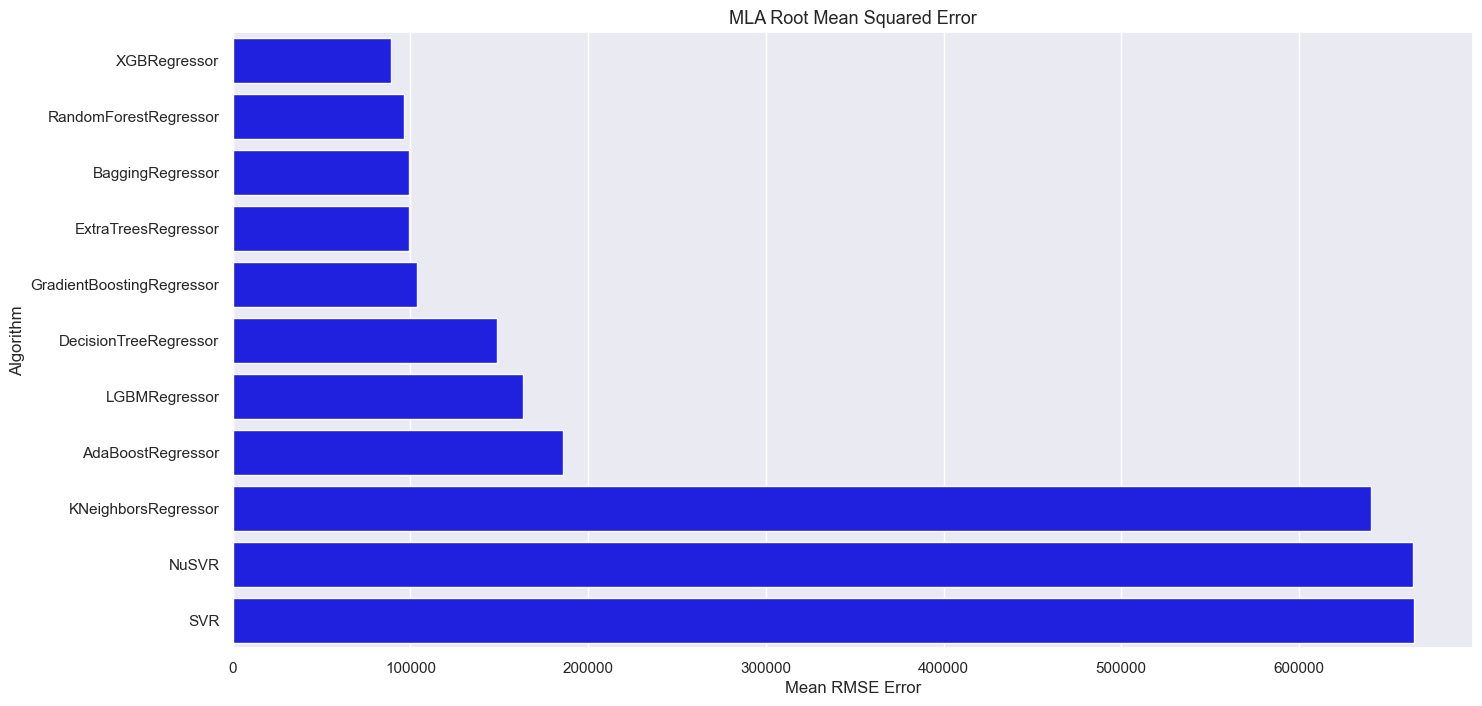

In [19]:
MLA_algos.sort_values('MLA Test RMSE Mean', inplace = True, ascending = True)

fig, ax = plt.subplots(figsize = [16,8])

sns.barplot(x = 'MLA Test RMSE Mean', y = 'MLA Name', data = MLA_algos, color = 'blue')
plt.title('MLA Root Mean Squared Error', fontsize=13)
plt.xlabel('Mean RMSE Error')
plt.ylabel('Algorithm')
plt.show()

> Top 7 appear to be roughly the same

> Notice a considerable drop off between AdaBoost and KNN

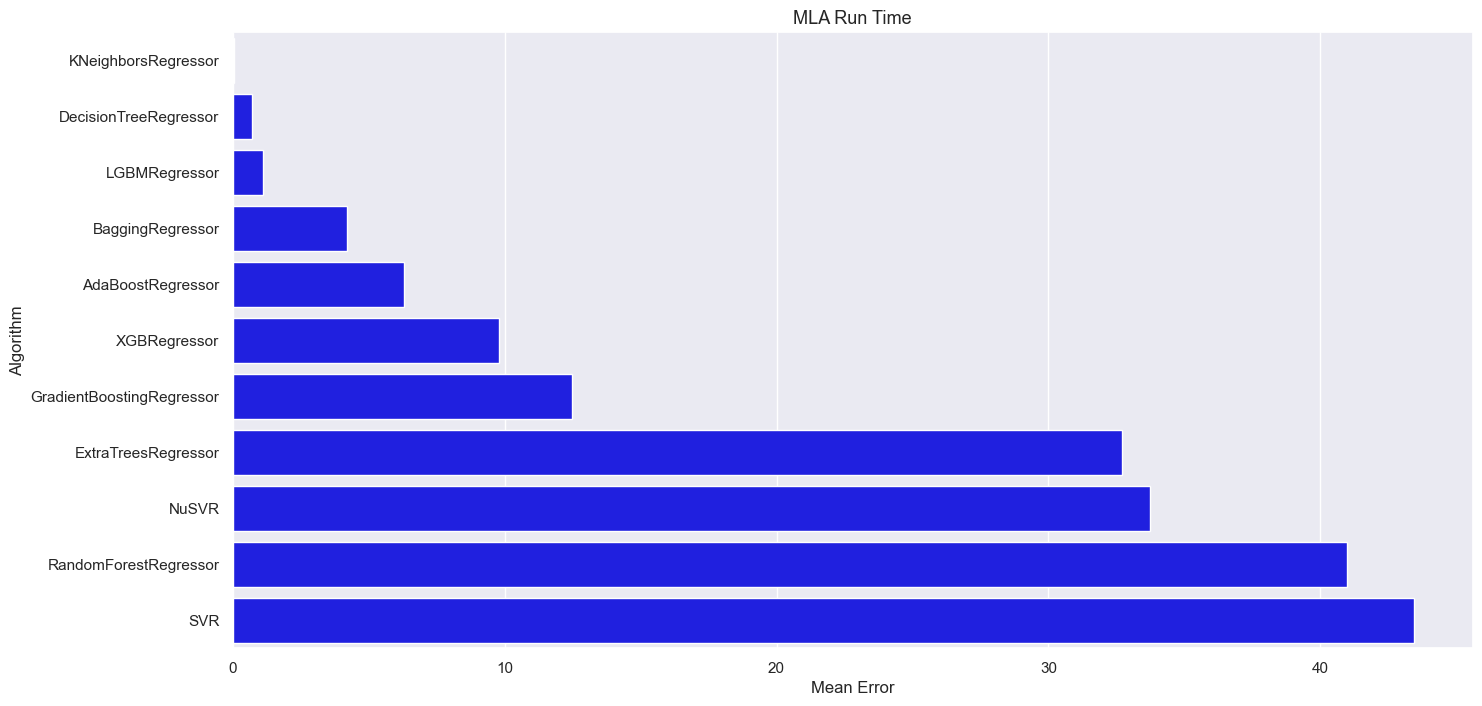

In [20]:
MLA_algos.sort_values('Total_Time', inplace = True, ascending = True)

fig, ax = plt.subplots(figsize = [16,8])

sns.barplot(x = 'Total_Time', y = 'MLA Name', data = MLA_algos, color = 'blue')
plt.title('MLA Run Time', fontsize=13)
plt.xlabel('Mean Error')
plt.ylabel('Algorithm')
plt.show()

> Anything beyond Gradient Boosting seems like it would take a long time when implementing Grid/Random/Bayesian Search methods

### Conclusion:
The top RMSE and MAE algorithms appear to be:

    - RandomForestRegressor (MAE: 1, RMSE: 2, Time: 11)
    - XGBoostRegressor (MAE: 3, RMSE: 4, Time: 6)
    - ExtraTreesRegressor (MAE: 1, RMSE: 3, Time: 8)
    - BaggingRegressor (MAE: 5, RMSE: 2, Time: 4)
    - GradientBoost (MAE: 4, RMSE: 5, Time: 7)
    - LGBMRegressor (MAE: 6, RMSE: 7, Time: 3)

However after taking time into consideration, narrow the choices down:

    - XGBoostRegressor
    - RandomForestRegressor

These final 2 models will be explored and optimized

Note: Any of these top 6 models would be a viable consideration however due to the limitations of time and computation, these 2 models were chosen. 

## Parameter_Optimization

In [21]:
X = processed_houses_w_dummies_yeo.drop(columns="final_price")
y = processed_houses_w_dummies_yeo['final_price']

There are several methods for hyperparameter optimization, including manual search, grid search, and random search.

- **Manual search** involves manually specifying a range of values to try for each hyperparameter, and then training and evaluating a model using each combination of values. This method is simple to implement but can be time-consuming if you have many hyperparameters to tune.

- **Grid search** is an automatic method for hyperparameter optimization that involves specifying a grid of values to search over for each hyperparameter. The search algorithm then trains and evaluates a model using each combination of values and returns the combination that performs the best.

- **Random search** is a variation of grid search that involves sampling random combinations of values from the grid instead of trying all possible combinations. This can be more efficient than grid search because it requires fewer evaluations to find good values for the hyperparameters.

In addition to these methods, there are also more advanced methods for hyperparameter optimization such as Bayesian optimization and evolutionary algorithms. These methods typically require specialized software and can be more computationally intensive, but can often find better values for the hyperparameters than grid search or random search.

Import Random Search as the primary method of searching

In [22]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## XGBoost
#### Random Search with XGBoost
eXtreme Gradient Boosting (XGBoost). XGBoost is an implementation of Gradient Boosting which tends to be faster and more accurate than the scikit-learn implementation. It also has several modifications to the underlying fitting method which tend to help in practice. Also for this reason, chosen to choose XGB over GradientBoosting from prior.

[Guide to using XGBoost with GridSearch](https://www.youtube.com/watch?v=9HomdnM12o4&ab_channel=KrishNaik)

Start by analyzing the default parameters and scoring the training data

In [23]:
xgbr = xgb.XGBRegressor()

In [24]:
xgbr.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)>

In [25]:
xgbr.fit(X_train, y_train)
score = xgbr.score(X_train, y_train)
print(f'Training Score {score}')

Training Score 0.9941329983662742


#### Find CV score

In [26]:
cv_score = cross_val_score(xgbr, X_train, y_train, cv = 10)
print(f'Average CV Score: {cv_score.mean()}')

Average CV Score: 0.9850266501919522


#### Use model to predict testing data and calculate MSE and RMSE

In [27]:
def get_rmse(predictions, true_values):
    # Calculate the residuals
    residuals = predictions - true_values

    # Calculate the squared residuals
    squared_residuals = residuals**2

    # Calculate the mean of the squared residuals
    mean_squared_residuals = np.mean(squared_residuals)

    # Calculate the square root of the mean squared residuals
    root_mean_squared_residuals = np.sqrt(mean_squared_residuals)

    return root_mean_squared_residuals

def get_mae(predictions, true_values):

    # Calculate the absolute differences
    abs_differences = np.abs(predictions - true_values)

    # Calculate the mean of the absolute differences
    mae = np.mean(abs_differences)
    
    return mae

In [28]:
y_pred = xgbr.predict(X_test)

# Transform data back to normal state
y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
y_test_xgb = pt.inverse_transform(pd.DataFrame(y_test))  * 100

mae = get_mae(y_pred,y_test_xgb)
rmse = get_rmse(y_pred, y_test_xgb)
print(f'mae: {mae}')
print(f'rmse: {rmse}')

mae: 40932.748568842224
rmse: 78303.61867493184


#### Plot results for better visual

Transform data back to normal for plotting

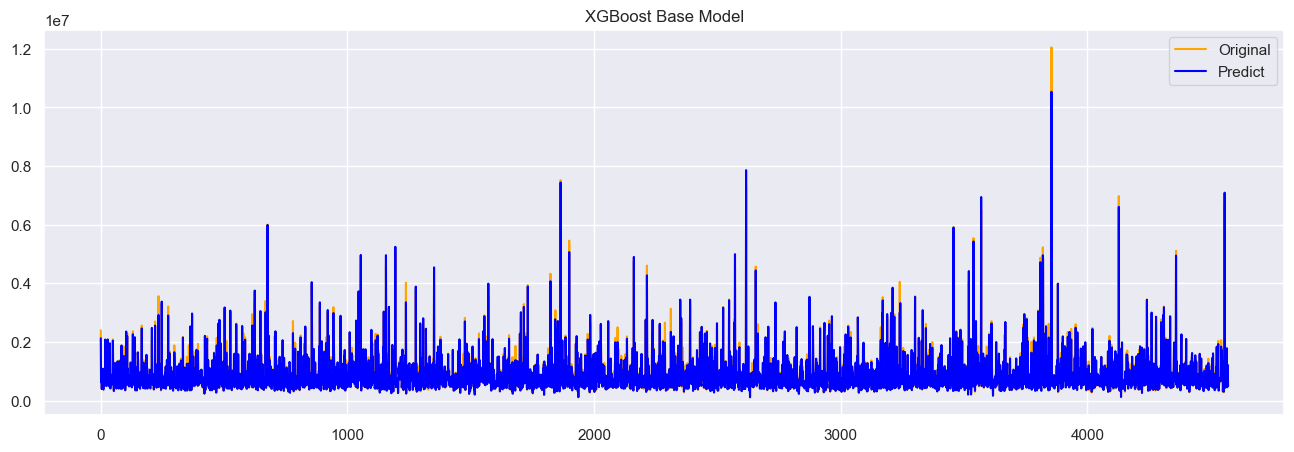

In [29]:
x_ax = range(len(y_test)) # define range for x axis
# plot
plt.figure(figsize = (16,5))
plt.plot(x_ax, y_test_xgb, label = 'Original', color = 'orange') # plot y_test values
plt.plot(x_ax, y_pred,label = 'Predict', color = 'blue') # plot prediction values
plt.title('XGBoost Base Model')
plt.legend()

Zoom in to the first 100 entries

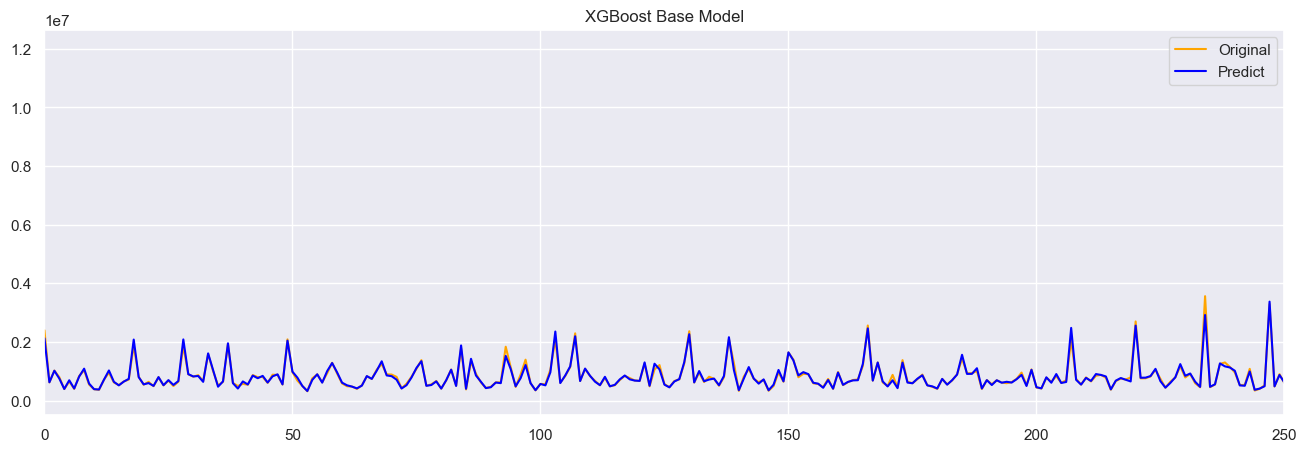

In [30]:
x_ax = range(len(y_test))
plt.figure(figsize = (16,5))
plt.plot(x_ax, y_test_xgb, label = 'Original', color = 'orange') # plot y_test values
plt.plot(x_ax, y_pred, label = 'Predict', color = 'blue') # plot prediction values
plt.xlim([0,250]) # set x limit for zooming
plt.title('XGBoost Base Model')
plt.legend()

#### Findings: 
Trying to guage a result via plotting appears difficult so the optimal way to move onwards is to track the mae and rmse the goal is to optimize and find values that are lower than these base values:

>mae: 40311.69666931799

>rmse: 83299.75026624807

In [31]:
params = {
    #'objective': 'reg:squarederror',
    'booster': ['gbtree', 'gblinear','dart'],
    'learning_rate': [0.05,0.10, 0.15,0.20,0.25, 0.30,0.35,0.40],
    'max_depth': [1, 3, 6, 12, 15, 20,30],
    'min_child_weight': [1, 3, 5, 7, 15],
    'gamma': [0.0, 0.2, 0.4, 0.6, 0.9],
    'colsample_bytree': [0.2, 0.4, 0.5, 0.7, 0.9],
    'n_estimators=100':[50,100,200,400,800]
}

In [32]:
random_search = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=params,
    n_iter=10, 
    n_jobs=-1,
    cv=4, verbose=3)
random_search.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[06:33:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { n_estimators=100 } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_par...
                                          tree_method='exact',
                                          validate_parameters=1,
                   

In [33]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.6, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=15,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_estimators=100=100, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [34]:
y_pred = random_search.predict(X_test)

# Transform data back to normal state
y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
y_test_xgb = pt.inverse_transform(pd.DataFrame(y_test))  * 100

mae = get_mae(y_pred,y_test_xgb)
rmse = get_rmse(y_pred, y_test_xgb)
print(f'mae: {mae}')
print(f'rmse: {rmse}')

mae: 49818.48132027107
rmse: 115188.24805565721


Unfortunately the parameters that were inputted in Random Search were unable to optimize for MAE / RMSE over the base model. Some important notes to improve model in future iterations: 

- Add more parameters and further research into what affects scoring
- Implement a more robust scoring calculator or re-run X,y train/test split without transformer
- Re run functions and evaluate for loss instead
[A Gentle Introduction to XGBoost Loss Functions](https://machinelearningmastery.com/xgboost-loss-functions/)

## RandomForest
#### GridSearch with RandomForestRegressor
A random forest regressor is an ensemble learning method that uses multiple decision trees to make predictions. In a random forest regressor, each tree in the ensemble is trained on a random subset of the training data, and the predictions of all the trees are combined to make the final prediction. This can help to improve the model's performance and reduce overfitting.

Instantiate regressor

In [35]:
rdmf = RandomForestRegressor()

Check default parameters

In [36]:
rdmf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Fit data and check score

In [37]:
rdmf.fit(X_train, y_train)
score = rdmf.score(X_train, y_train)
print(f'Training Score {score}')

Training Score 0.9978596162982388


Check cross validation score for accuracy

In [38]:
cv_score = cross_val_score(rdmf, X_train, y_train, cv = 10)
print(f'Average CV Score: {cv_score.mean()}')

Average CV Score: 0.9844031403023286


Calculate MSE and RMSE

In [39]:
y_pred = rdmf.predict(X_test)

# Transform data back to normal state
y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
y_test_xgb = pt.inverse_transform(pd.DataFrame(y_test))  * 100

mae = get_mae(y_pred,y_test_xgb)
rmse = get_rmse(y_pred, y_test_xgb)
print(f'mae: {mae}')
print(f'rmse: {rmse}')

mae: 41054.117141444556
rmse: 78247.78059071267


Use grid search instead of random search

In [40]:
params_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=10,stop=80,num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [2,4,8,16],
    'min_samples_split': [2,3,5,8],
    'min_samples_leaf': [1,2,4],
    'bootstrap': [True,False]
}

In [41]:
rf_grid = GridSearchCV(estimator= rdmf, param_grid=params_grid, # scoring=mean_squared_error, <-- having issues with this
                       cv = 3, verbose = 1, n_jobs = 4)

In [42]:
rf_grid.fit(X_train, y_train)

[06:33:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { n_estimators=100 } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/4] END booster=dart, colsample_bytree=0.7, gamma=0.6, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100=100; total time=  19.5s
[06:33:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { n_estimators=100 } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/4] END booster=dart, colsample_bytree=0.2, gamma=

[06:33:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { n_estimators=100 } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/4] END booster=dart, colsample_bytree=0.5, gamma=0.4, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=100=400; total time=  14.8s
[06:33:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { n_estimators=100 } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/4] END booster=dart, colsample_bytree=0.2, gamma=

/Users/arnoldwang/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/arnoldwang/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/arnoldwang/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/arnoldwang/opt/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int

Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4, 8, 16],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 3, 5, 8],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=1)

In [43]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 16,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 72}

In [44]:
rf_grid.best_score_

0.9841485248669599

In [45]:
# Best parameters from grid search
# {'bootstrap': True,
#  'max_depth': 16,
#  'max_features': 'auto',
#  'min_samples_leaf': 2,
#  'min_samples_split': 5,
#  'n_estimators': 72}

In [46]:
best_grid_result = RandomForestRegressor(bootstrap=True, max_depth=32, max_features = 'auto', 
                                         min_samples_leaf=4,min_samples_split=4, n_estimators = 80)
                                         
best_grid_result.fit(X_train, y_train)

RandomForestRegressor(max_depth=32, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=80)

In [47]:
y_pred = best_grid_result.predict(X_test)

# Transform data back to normal state
y_pred = pt.inverse_transform(pd.DataFrame(y_pred))  * 100
y_test_xgb = pt.inverse_transform(pd.DataFrame(y_test))  * 100

mae = get_mae(y_pred,y_test_xgb)
rmse = get_rmse(y_pred, y_test_xgb)
print(f'mae: {mae}')
print(f'rmse: {rmse}')

mae: 41573.27170194701
rmse: 89553.65039150538


The grid search was able to optimize for a lower rmse however the mae still remains around the ~40400 mark. 

In [48]:
# Try Random search instead
# rdm_forest_rdm_search = RandomizedSearchCV(
#     estimator=rdmf,
#     param_distributions=params_grid,
#     n_iter=10, 
#     n_jobs=-1,
#     cv=4, verbose=3)
# rdm_forest_rdm_search.fit(X_train, y_train)

## Conclusions
#### Final thoughts and steps moving onwards:

Optimized XGBRegressor yielded the best overall score of 
Training Score 0.9939406236651268
Average CV Score: 0.9846563459149543
mae: 40311.69666931799
rmse: 83299.75026624807

Optimized RandomForest yielded the best overall score of 
Training Score 0.9978190934673239
Average CV Score: 0.9837913399065471
mae: 40414.60283737884
rmse: 77728.39013963753

Conclusions: For XGBoost, Random Search was implemented however GridSearch was used for RandomForest. Despite this, results tended to be similar as trained model appears somewhat be able to interpret the testing set with an absolute error rate of 40,000 dollars. This may seem like a lot of money however when considering the mean/median price of a home is 450,000 and more, this means there is only about a 5-10% error rate which ideally would be considered a success given the variability of other outside factors when determining a true price of real estate. It may be worth attempting to forego the use of transformations in favor of scaling or removing both entirely future iterations. Overall consider these beginning models to be a success

While mean squared error and mean absolute error are important factors in determining regressor quality, upon further research, there are several metrics that can be used to evaluate a regression model, including mean absolute error, mean squared error, and root mean squared error. Other metrics that may be used include R-squared, which measures the proportion of variance in the dependent variable that is explained by the model, and the adjusted R-squared, which adjusts for the number of predictors in the model. Additionally, some people may use the F-statistic to evaluate the overall fit of the model. 

Exploring only MSE and RMSE in the models may have lead to a plateau as other metrics should be explored moving forward.

In revisiting the capstone for refinement (in preperation for demo day and personal use) these are the improvements to touch upon:

- Revising the dataset to include listings from previous and recent dates
    - Webscraping
- Include sold dates for time series analysis and seasonality feature importance
- When measuring accuracy, focus on not only mae and rmse but other factors as well
- Better hyperoptimization:
    - Use hyperopt and bayesian search methods
    - Use more models